In [4]:
import os

from ml.eval import eval_model

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline, ModelPipeline

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

name = 'MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-lr-schedule'

/home/jelinek/recetox


In [5]:
from tensorflow.keras.optimizers import schedules, Adam


def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1',
                        kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])  # SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X


class MySimpleCnn_Feit(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 300
        self.batch_size = 16
        self.params.tile_size = 256

    def get_optimizer(self):
        lr_schedule = schedules.ExponentialDecay(
                        initial_learning_rate=1e-3,
                        decay_steps=125,
                        decay_rate=0.1,
                        staircase=True)

        return ( Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999))

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1, 1), pool_size=(3, 3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3, 3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5, 5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1, 1), padding='same')(p1)

        output_layer = keras.layers.concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer

    @staticmethod
    def get_compiled_model(input_shape=(256, 256, 3)):
        X_input = keras.layers.Input(input_shape)

        X = keras.layers.ZeroPadding2D((3, 3))(X_input)

        X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = keras.layers.Activation('relu')(X)
        X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = convolutional_block(X, f=3, filters=[8, 8, 32], stage=2, block='a', s=1)
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='b')
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='c')

        X = convolutional_block(X, f=3, filters=[16, 16, 64], stage=3, block='a', s=2)
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='b')
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='c')
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='d')

        X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=4, block='a', s=2)
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='b')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='c')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='d')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='e')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='f')

        X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=5, block='a', s=2)
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='b')
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='c')

        X = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        X = keras.layers.Flatten()(X)
        X = keras.layers.Dense(units=12, activation='softmax')(X)

        model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')

        model.summary()

        return model

    def _train_model(self, data_train, data_valid):

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, PlotLossesKerasTF()])

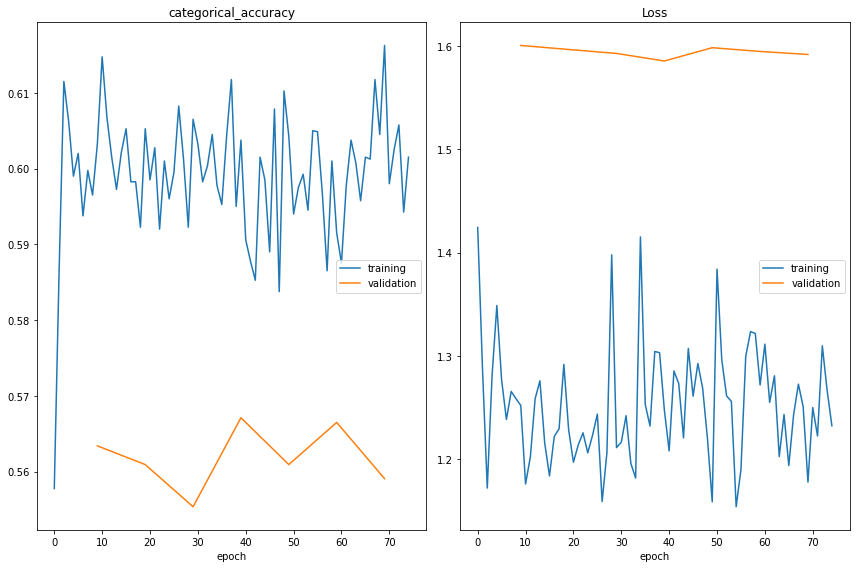

categorical_accuracy
	training         	 (min:    0.558, max:    0.616, cur:    0.601)
	validation       	 (min:    0.555, max:    0.567, cur:    0.559)
Loss
	training         	 (min:    1.154, max:    1.424, cur:    1.232)
	validation       	 (min:    1.586, max:    1.601, cur:    1.592)
Epoch 76/200
 76/250 [========>.....................] - ETA: 10s - loss: 1.0860 - categorical_accuracy: 0.6118

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3006393/50493812.py", line 5, in <module>
    pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)
  File "/home/jelinek/recetox/src/ml/pipeline.py", line 116, in execute_pipeline
    self._train_model(data_train, data_valid)
  File "/tmp/ipykernel_3006393/881618154.py", line 145, in _train_model
    self.model.fit(data_train,
  File "/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1183, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/home/jelinek/anaconda3/envs/rec

TypeError: object of type 'NoneType' has no len()

In [6]:
pipeline = MySimpleCnn_Feit(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                            valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

keras.utils.plot_model(pipeline.model, 'model-figs/' + name + '.png')
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [ ]:
pipeline.save_pipeline()

In [ ]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)